# Exploring a maze by very simple Q-learning algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

First of all, we have to define a maze as class. We are going to create a new maze by only two argments: the size of the new maze (maze_size) so that the shape of the new maze will be (maze_size, maze_size) and number of obstacles (num_obst) which are assigned randomly to the various locations in the maze.

In [2]:
class Maze():
    def __init__(self, maze_size=10, num_obst=20):
        obstacle = np.random.choice(maze_size*maze_size - 2, num_obst, replace=False)
        
        # to avoid to put obstacles in the entrance (lower-left corner) or the exit (upper-right corner)
        for i in range(len(obstacle)):
            if obstacle[i] >= maze_size-1:
                obstacle[i] += 1
                if obstacle[i] >= maze_size*(maze_size-1):
                    obstacle[i] += 1
                    if obstacle[i] >= maze_size*maze_size:
                        obstacle[i] -= maze_size*maze_size
        
        self.obstacle = list(obstacle)
        self.size = maze_size
    
    # This method translate each location on 2D-coordinate (x, y) of the square-shaped maze into 1D. For example, if the size of the maze is 
    #10 x 10, the coordinate (3, 5) becomes (5-1)*10 + 3 = [43] on the 1D coordinate.
    def coordinate2index(self, location):
        
        if type(location) == list and type(location[0]) == list:
            for i in range(len(location)):
                location[i] = np.reshape(np.arange(self.size*self.size), [self.size, self.size])[location[i][0]][location[i][1]]
        
        elif type(location) == list and len(location) == 2 and type(location[0]) == int:
            location = np.reshape(np.arange(self.size*self.size), [self.size, self.size])[location[0]][location[1]]
        
        return location
    
    # To visualize the maze.
    def visualize(self):
        self.obstacle = self.coordinate2index(self.obstacle)
    
        self.map_ = np.ones([self.size, self.size])
        self.map_[-1,0], self.map_[0,-1] = 0,0

        self.map_ = np.reshape(self.map_, [1, self.map_.size])

        if type(self.obstacle) == list:
            for i in range(len(self.obstacle)):
                self.map_[0][self.obstacle[i]] = 2

        self.map_[0][self.obstacle] = 2
        self.map_ = np.reshape(self.map_, [self.size, self.size])
        sns.heatmap(self.map_)
        plt.show()

Next, we need the class of the agent, who tries to overcome the maze based on his/her own Q-learning matrix and algorithm.

In [3]:
class Agent():
    def __init__(self, states, actions):
        self.Qmat = np.random.random([states.size, len(actions)])
    
    # The agent take his action according to the values of his/her own matrix if the randomly generated value is larger than epsilon (the threshold 
    # between exploiting or exploring)
    def take_action(self, state, epsilon):
        if random.random() >  epsilon:
            action_idx = self.Qmat[state].argmax()
            self.action = actions[action_idx]
        else:
            self.action = random.choice(actions)
    
    def update_Q(self, alpha, gamma, Rmat, state, next_state, actions):
        self.Qmat[state, actions.index(self.action)] = self.Qmat[state, actions.index(self.action)] + alpha*(Rmat[next_state].max() + gamma*self.Qmat[next_state].max() - self.Qmat[state, actions.index(self.action)])

The same translation function as the Maze class'es method we have seen above.

In [4]:
def coordinate2index(maze_size, location):
    if type(location) == list and type(location[0]) == list:
        for i in range(len(location)):
            location[i] = np.reshape(np.arange(maze_size*maze_size), [maze_size, maze_size])[location[i][0]][location[i][1]]
    elif type(location) == list and len(location) == 2 and type(location[0]) == int:
        location = np.reshape(np.arange(maze_size*maze_size), [maze_size, maze_size])[location[0]][location[1]]
    return location

This function controls the state transition of the environment based on the action taken by the agent.

In [5]:
def state_transition(state, action, maze_size, obstacle):
    obstacle = coordinate2index(maze_size, obstacle)
    
    location = np.where(states == state)
    next_state_index = list([np.array(location)[0] + action[0], np.array(location)[1] + action[1]])
    if max(next_state_index) == maze_size or min(next_state_index) == -1: # cannot go because of wall
        next_state = state
    else:
        next_state = list(states[next_state_index])[0]
    
    if type(obstacle) == int:
        obstacle = [obstacle]
    
    if next_state in obstacle:   # cannot go because of obstacle
        next_state = state
    return next_state

We also have to set the reward funtion, which gives a big reward if the agent reaches the goal and a small negative reward if the agent have not reached yet.

In [6]:
def set_Rmat(states, actions, reward):
    #Rmat = np.zeros([states.size, len(actions)])
    Rmat = np.zeros([states.size, len(actions)]) - reward / 100
    Rmat[maze_size-1] = reward
    return Rmat

Now that we are ready to dive into the actual learning. Let's get started!
Firstly we would like to create the new maze. Note that the starting point is a white cell on the lower-left corner and the goal is a whilte cell on the upper-right corner. The agent can move on the purple cells avoiding black obstacles.

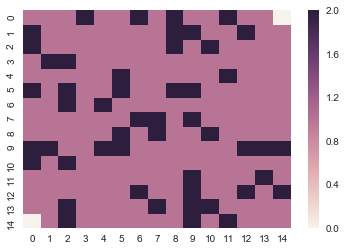

In [7]:
# Create a maze
maze_size = 15
num_obstacle = 50
m = Maze(maze_size, num_obstacle)
m.visualize()

In [8]:
# Define states and actions of the agent.
states = np.reshape(np.arange(maze_size**2), [maze_size,maze_size])
actions =[[0,1],[-1,0],[0,-1],[1,0]]

a = Agent(states, actions)

As the learning process proceeds, you will find the map becomes more and more likely to show the path clearly. This means that as the agent experiences a lot of trials and error, he/she becomes more confident which way to choose to reach the goal more efficiently.

step:0 MAP


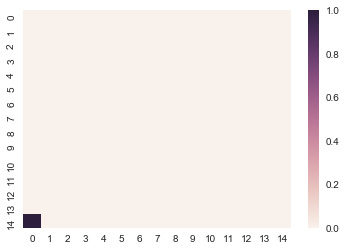

step:10000 MAP


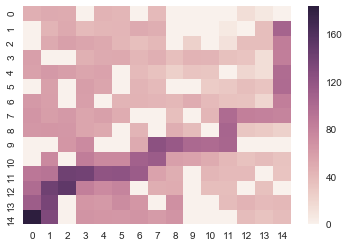

step:20000 MAP


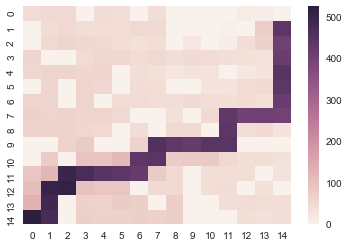

step:30000 MAP


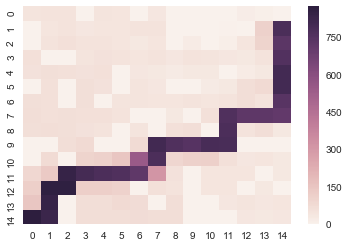

step:40000 MAP


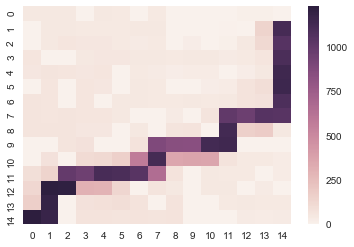

step:50000 MAP


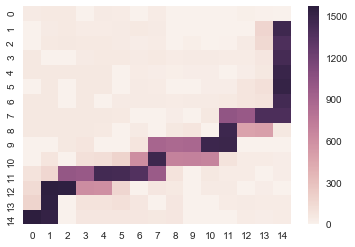

step:60000 MAP


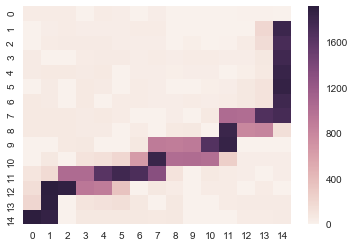

step:70000 MAP


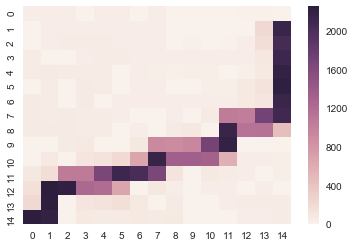

step:80000 MAP


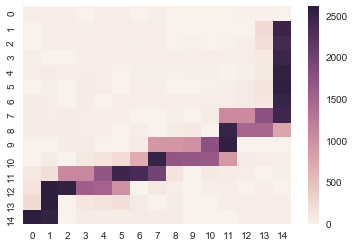

step:90000 MAP


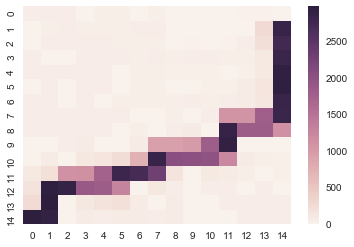

In [9]:
# learn

ALPHA = 0.9
GAMMA = 0.9
EPSILON = 0.1
REWARD = 10

Rmat = set_Rmat(states, actions, REWARD)

start = states[-1][0]
goal = states[0][-1]

state = start

history = []
goals = []

num_step = 100000

obstacle = m.obstacle

for step in range(num_step):
    a.take_action(state, EPSILON)
    next_state = state_transition(state, a.action, maze_size, m.obstacle)
    a.update_Q(ALPHA, GAMMA, Rmat, state, next_state, actions)
    history.append(state)
    if next_state == goal:
        state = start
        #print('step:{} Goal!'.format(step))
        goals.append(step)
    else:
        state = next_state
        
    if step % (num_step / 10) == 0:
        counter = [0] * maze_size * maze_size
        for i in range(len(history)):
            counter[history[i]] += 1
        sns.heatmap(np.reshape(np.array(counter), [maze_size, maze_size]))
        print('step:{} MAP'.format(step))
        plt.show()

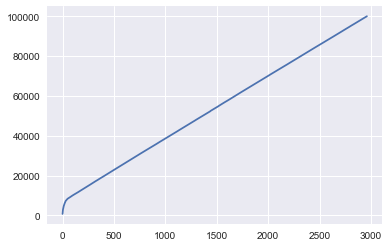

In [10]:
plt.plot(goals)

Let's visualize the values of Q-matrix built in the agent. Agent tends to go to the most red cell among the four cells surrounding him/her.

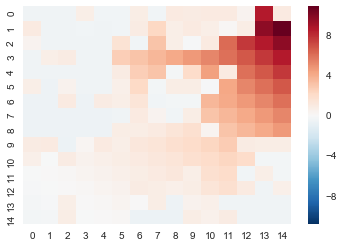

In [11]:
# visualize Q-value
sns.heatmap(a.Qmat.max(axis=1).reshape([maze_size, maze_size]))

In [12]:
#test
EPSILON = 0
history_test = []

state = start

for step in range(100):
    a.take_action(state, EPSILON)
    next_state = state_transition(state, a.action, maze_size, m.obstacle)
    if next_state == goal:
        state = start
    else:
        state = next_state
    history_test.append(state)

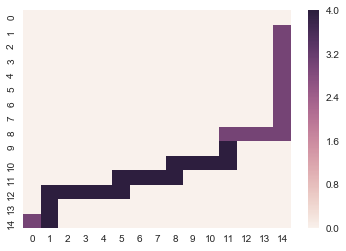

In [13]:
# visualize performance of learned agent
counter = [0] * maze_size * maze_size
for i in range(len(history_test)):
    counter[history_test[i]] += 1
sns.heatmap(np.reshape(np.array(counter), [maze_size, maze_size]))